## Python programs

 - Mean monthly CG flash density for a region; [~ 1km grid](#1km-grid)
 - Mean monthly [diurnal cycle](#diurnal-cycle) of CG flash density by month for a region
 - Largest 100 CG flash density days (12 UTC - 12 UTC) for a region
 - JJA time (UTC) of maximum CG flash density (15 minute time resolution); ~ 1 km grid
 - “Amplitude” of the diurnal cycle; 15 minute time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 
 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from __init__ import *
from plotting import *

%matplotlib inline

If you have already install dask (in terminal: `conda install dask`), the files are in good order, and all have the same variables, then this will work:

    xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/2014_01_*.nc', concat_dim='record')

If they don't have the same variables, then we can use the preprocess keyword to get just the variables that we know are in all the datasets:

    xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/*_04_*.nc', 
                      concat_dim='record', preprocess=(lambda x: x[['strokes', 'amplitude']])

In [3]:
ds = xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/Cedar_City_UT/*_07_*.nc', 
                       concat_dim='record', preprocess=(lambda x: x[['strokes', 'amplitude']]))

## 1km grid

Once we have all the settings and imports, we should grid the data. This is a good [example](http://stackoverflow.com/questions/11015252/countig-points-in-boxes-of-a-grid) of how we will go about doing that. The premise is that we want to count the strikes within each bin, so we can use a 2D histogram.

In [6]:
x = ds.lon.values
y = ds.lat.values

gridx = np.linspace(x.min(), x.max(), 600)
gridy = np.linspace(y.min(), y.max(), 600)

grid, _, _ = np.histogram2d(x, y, bins=[gridx, gridy])
density = grid.T

In [9]:
np.round(density.mean()

10.317334678554408

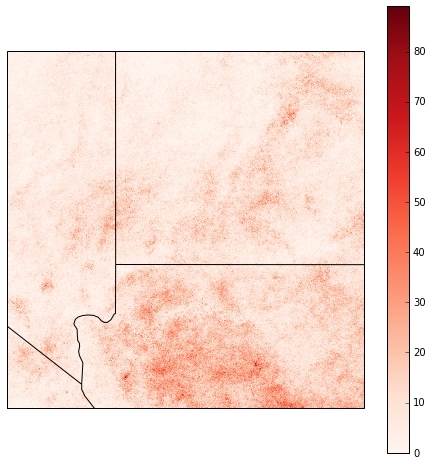

In [8]:
plt.figure(figsize=(8,6))
ax = background(plt.axes(projection=ccrs.PlateCarree()))
den = ax.pcolor(gridx, gridy, density, cmap='Reds')
plt.colorbar(den, ax=ax)

## Object orientation

These are constant variables for each region so it makes to define a class to hold info and functions relating to the region. This is a first pass at such a class:

In [150]:
class Region:
    def __init__(self, ds=None, **kwargs):
        if 'city' in kwargs:
            city = kwargs['city']
            self.CENTER = (city['lat'], city['lon'])
            self.RADIUS = city['r']
        else:
            self.CENTER = (lat, lon)
            self.RADIUS = (r)
        if type(ds) == xr.Dataset:
            self.get_x_y(ds)
    
    def define_grid(self, nbins, extents=[], **kwargs):
        if len(extents) > 0:
            minx, maxx, miny, maxy = extents
        else:
            minx = self.CENTER[1]-self.RADIUS
            maxx = self.CENTER[1]+self.RADIUS
            miny = self.CENTER[0]-self.RADIUS
            maxy = self.CENTER[0]+self.RADIUS
        self.gridx = np.linspace(minx, maxx, nbins)
        self.gridy = np.linspace(miny, maxy, nbins)
    
    def get_x_y(self, ds):
        self.x = ds.lon.values
        self.y = ds.lat.values
        
    def __to_grid(self, group=None, **kwargs):        
        if hasattr(group, '__iter__'):
            grid, _, _ = np.histogram2d(self.x[group], self.y[group], bins=[self.gridx, self.gridy], **kwargs)
        else:
            grid, _, _ = np.histogram2d(self.x, self.y, bins=[self.gridx, self.gridy], **kwargs)
        return(grid.T)
    
    def to_diurnal(self, ds):
        if not hasattr(self, 'x'):
            self.get_x_y(ds)
        gb = ds.groupby('time.hour')
        d = {}
        for k, v in gb.groups.items():
            d.update({k: self.__to_grid(v)})
        self.diurnal = d

## diurnal cycle


In [151]:
c = Region(city=cities['cedar'], ds=ds)
c.define_grid(nbins=60)
c.to_diurnal(ds)

In [154]:
h = range(12,24)
h.extend(range(0,12))

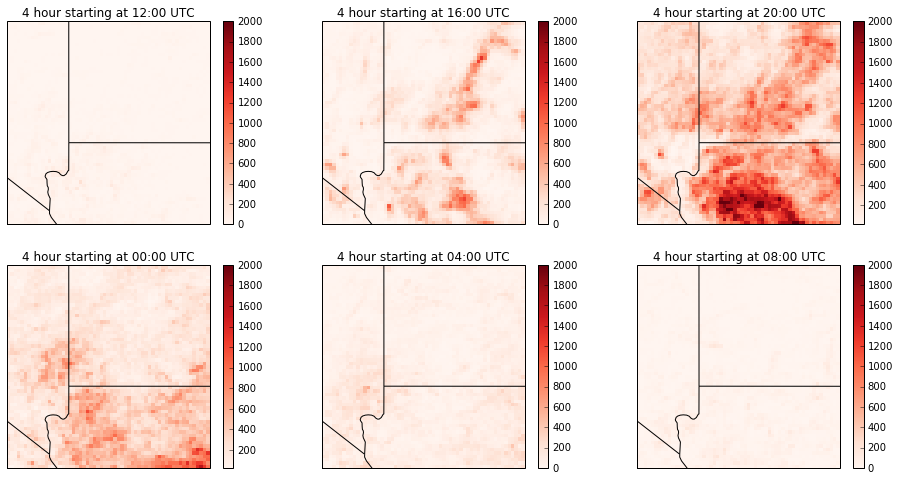

In [155]:
plt.figure(figsize=(16,8))
n=1
step = 4
for i in range(0,24,step):
    q=np.zeros(c.diurnal[0].shape)
    for hr in h[i:i+step]:
        q+=d[hr]
    ax = plt.subplot(2, 3, n, projection=ccrs.PlateCarree())
    ax = background(ax)
    ax.set_title('{step} hour starting at {t:02d}:00 UTC'.format(step=step, t=h[i]))
    den = ax.pcolor(gridx, gridy, q, cmap='Reds', vmax=2000)
    plt.colorbar(den, ax=ax)
    n+=1